In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
datadir='/content/drive/MyDrive'
os.chdir(datadir)

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

class DriverSegmentationDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        self.image_list = []
        self.label_list = []
        
        if self.mode == 'train':
            for class_name in os.listdir(os.path.join(self.root_dir, 'train')):
                class_id = int(class_name[1])
                class_path = os.path.join(self.root_dir, 'train', class_name)
                
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    
                    if os.path.exists(img_path):
                        self.image_list.append(img_path)
                        self.label_list.append(class_id)
                    else:
                        print(f"Warning: Image not found: {img_path}")

        elif self.mode == 'val':
            for class_name in os.listdir(os.path.join(self.root_dir, 'val')):
                class_id = int(class_name[1])
                class_path = os.path.join(self.root_dir, 'val', class_name)
                
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    
                    if os.path.exists(img_path):
                        self.image_list.append(img_path)
                        self.label_list.append(class_id)
                    else:
                        print(f"Warning: Image not found: {img_path}")
                        
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.label_list[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [12]:
import torchvision.transforms as transforms

# Define train and test transforms
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define train and val datasets
train_dataset = DriverSegmentationDataset('/content/drive/MyDrive/final', transform=train_transforms, mode='train')
val_dataset = DriverSegmentationDataset('/content/drive/MyDrive/final', transform=val_transforms, mode='val')

# Define train and val dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
import torch.nn as nn
import torchvision

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, x):
        outputs = []
        for model in self.models:
            output = model(x)
            outputs.append(output.unsqueeze(dim=1))
        outputs = torch.cat(outputs, dim=1)
        predictions = outputs.mode(dim=1).values
        return predictions


In [15]:
import torch.nn as nn
import torchvision
import torch.optim as optim

# ResNet18
model1 = torchvision.models.resnet18(pretrained=True)
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, 10)
model1.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model1 = model1.to(device)

# VGG16
model2 = torchvision.models.vgg16(pretrained=True)
model2.classifier[6] = nn.Linear(4096, 10)
model2.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
model2 = model2.to(device)

# DenseNet121
model3 = torchvision.models.densenet121(pretrained=True)
num_features = model3.classifier.in_features
model3.classifier = nn.Linear(num_features, 10)
model3.features.conv0 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model3 = model3.to(device)


ensemble_model = EnsembleModel([model1, model2, model3]).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
 

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Train the model
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for epoch in range(epochs):
    train_loss, train_acc = 0, 0
    val_loss, val_acc = 0, 0
    i = 0
    # Train loop
    ensemble_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = ensemble_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

Epoch 1/10, Train Loss: 1.2914, Train Acc: 0.5118
Epoch 2/10, Train Loss: 0.5954, Train Acc: 0.7633


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69a3b8d3f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f69a3b8d3f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 3/10, Train Loss: 0.3361, Train Acc: 0.8718
Epoch 4/10, Train Loss: 0.2073, Train Acc: 0.9367
Epoch 5/10, Train Loss: 0.1325, Train Acc: 0.9598
Epoch 6/10, Train Loss: 0.1010, Train Acc: 0.9716
Epoch 7/10, Train Loss: 0.1089, Train Acc: 0.9699
Epoch 8/10, Train Loss: 0.0501, Train Acc: 0.9846
Epoch 9/10, Train Loss: 0.0433, Train Acc: 0.9879
Epoch 10/10, Train Loss: 0.0216, Train Acc: 0.9933


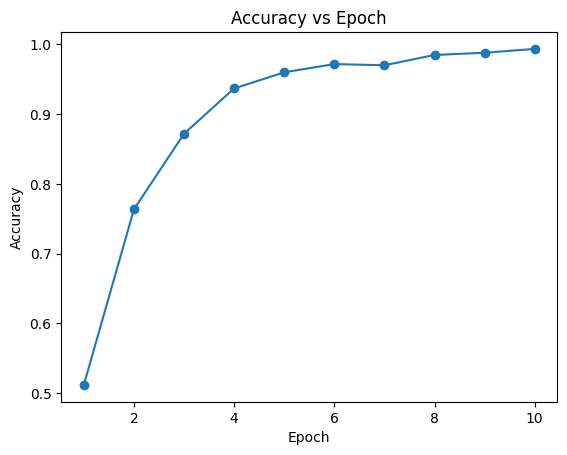

In [20]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 11)]

plt.plot(epochs, train_accs, marker='o')

# set the title and labels
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# display the plot
plt.show()

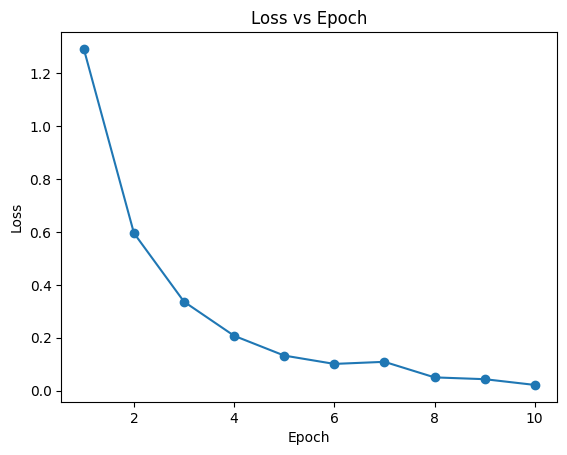

In [2]:
plt.plot(epochs, train_losses, marker='o')

# set the title and labels
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# display the plot
plt.show()

In [22]:
torch.save(ensemble_model.state_dict(), '/content/drive/MyDrive/model_ensemble_dict_final_final.pth')

In [23]:
# Test the model
ensemble_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = ensemble_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = correct / total
print(f'Validation Acc: {val_acc:.4f}')

Validation Acc: 0.9715


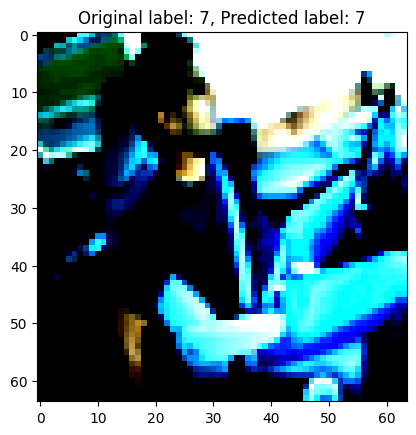

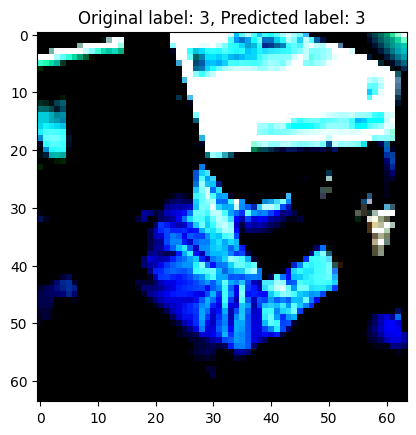

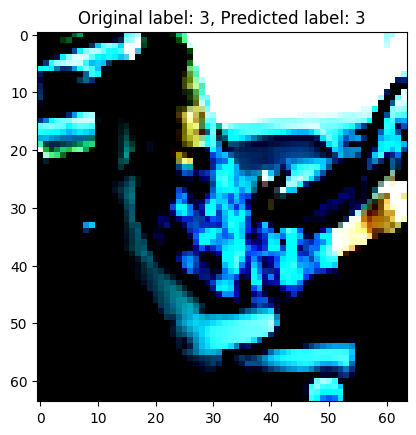

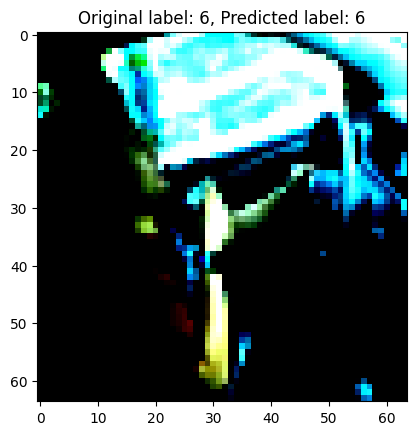

In [24]:
ensemble_model.eval()
with torch.no_grad():
    counter = 0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = ensemble_model(images)
        preds = outputs.argmax(dim=1)

        for i in range(images.shape[0]):
            counter += 1
            if counter > 4:
                break
            plt.imshow(images[i].permute(1, 2, 0).cpu())
            plt.title(f"Original label: {labels[i].item()}, Predicted label: {preds[i].item()}")
            plt.show()